# Algoritmo

Se analizó la viabilidad de diversos algoritmos (DBSCAN, agrupamiento por jerarquía y mezclas gaussianas; se excluyó Kmedias debido a que se desarrolló en clase). 

Con base en algunas pruebas rápidas, se detectó que el agrupamiento por jerarquía era sensible a la profundidad de los objetos de los fotogramas. Por ejemplo, la esponja delante de la pared, etc. Esto resulta problemático cuando se quiere generalizar el proceso para varios fotogramas, ya que la variación del fondo con el movimiento de la prensa mecánica cambiaría el número de clústeres necesarios. La deformación podría tener el mismo efecto.

En el caso de las mezclas gaussianas, se consideró que las esponjas con el brazo mecánico tienen características físicas *afiladas* y con cambios bruscos, por lo que se consideró que este algoritmo podría no ajustar correctamente en todos los casos.

DBSCAN, por su parte, debido a su agrupamiento por densidad podría ser más pertinente. Si se piensa en el tipo de datos con el que se trabaja: espacios de colores, DBSCAN podría agrupar aquellas regiones con valores del espectro de color que sean similares, lo que significaría agrupar amarillos con amarillos; azules con azules. Definir lo que es un color puede ser complejo, pero la forma en la que puntos frontera se acoplan a los grupos me parece similar a cuando intuitivamente nombramos a un color. Además que el algoritmo permite agrupar regiones de diversas formas.

# Carga de datos y formato

In [1]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import time as time
import matplotlib.pyplot as plt

In [2]:
from crea_tabla import *
from preprocesamiento import *

`NOTA`

Se modificó la función `obtén_tabla_datos` para reescalar la imagen a un porcentaje del alto y ancho original; esto permite aligerar el tiempo de ejecución.

Se creó una serie de funciones de preprocesamiento en `preprocesamiento.py` basado en el resultado de `obtén_tabla_datos` para evitar modificarla más.

In [21]:
# Carcga de datos
conjuntos = [0, 30, 75]
datos, originales = obtén_tabla_datos(conjuntos=conjuntos, rescale = 0.25)

Leyendo numpy...
Organizando renglones...
Creando tabla de datos...
Terminado


In [22]:
# Se ordenan las imágenes originales en un diccionario
images_data = datos.groupby('f')
_, originals = ordenar_datos(images_data, originales)

In [23]:
# Se preprocesan las imágenes seleccionadas
datos = {}
for key,value in originals.items():
    datos[key] = preprocess(value)

# Entrenamiento

In [32]:
def train_dbscan(datos, original, ax_row):
    '''
    datos : Array de características de los datos (n,8)
    original: Array de la imagen original  con shape (h,w,3)
    '''
    ## Estandarización
    stscaler = StandardScaler().fit(datos)
    np_datos_escalados = stscaler.transform(datos)

    # Entrenamiento de DBSCAN
    min_samples = int(len(np_datos_escalados) * 0.01)
    t_ini = time.time()
    dbsc = DBSCAN(eps = 0.4, min_samples = min_samples).fit(np_datos_escalados)
    print(f"Tiempo transcurrido: {time.time() - t_ini:.3f}s")


    # Máscaras resultantes
    labels = dbsc.labels_
    core_samples = np.zeros_like(labels, dtype = bool)
    core_samples[dbsc.core_sample_indices_] = True

    # Visualización
    rens = originales[0].shape[0]
    cols = originales[0].shape[1]
    grupos = labels.reshape((rens, cols))

    ax_row[0].imshow(original.astype(int))
    ax_row[1].imshow(grupos)
    return labels

### min_samples = 776 | $\epsilon = 0.4$

Tiempo transcurrido: 4.711s
Tiempo transcurrido: 4.358s
Tiempo transcurrido: 4.610s


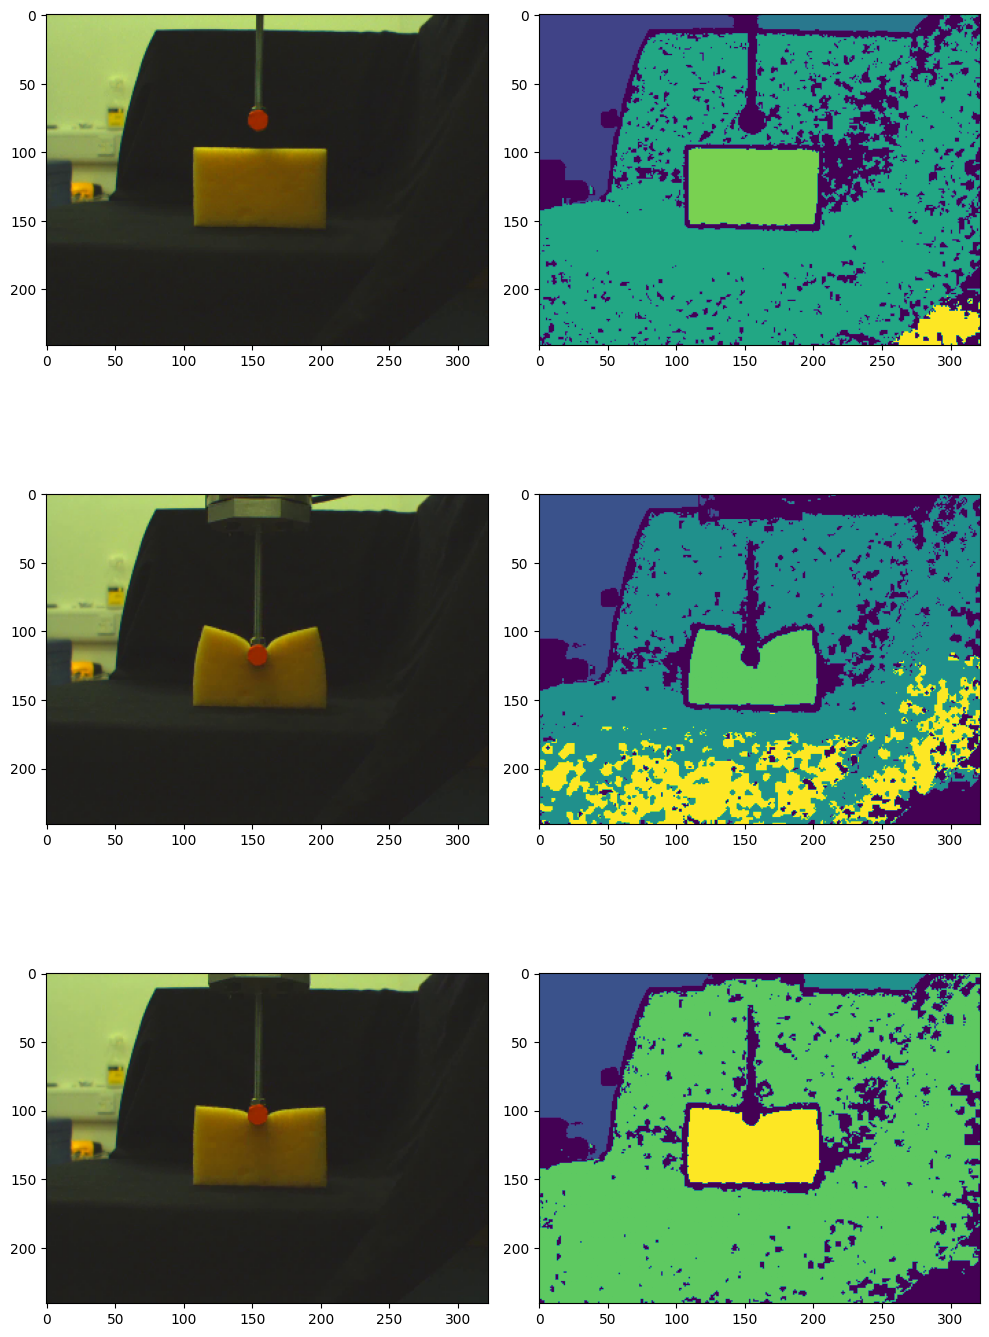

In [33]:
fig, axs = plt.subplots(3,2, figsize = (10,15))

labels = {}
for i, (image_pre, image_real, ax) in enumerate(zip(datos.values(), originals.values(), axs)): # Pendiente por ordenar código
    image_process = image_pre.drop(['V', 'R', 'G', 'B'], axis=1)
    labels[list(datos.keys())[i]] = train_dbscan(image_process, image_real, ax)

fig.tight_layout()

### min_samples = 776 | $\epsilon = 0.5$

Tiempo transcurrido: 6.774s
Tiempo transcurrido: 6.117s
Tiempo transcurrido: 6.065s


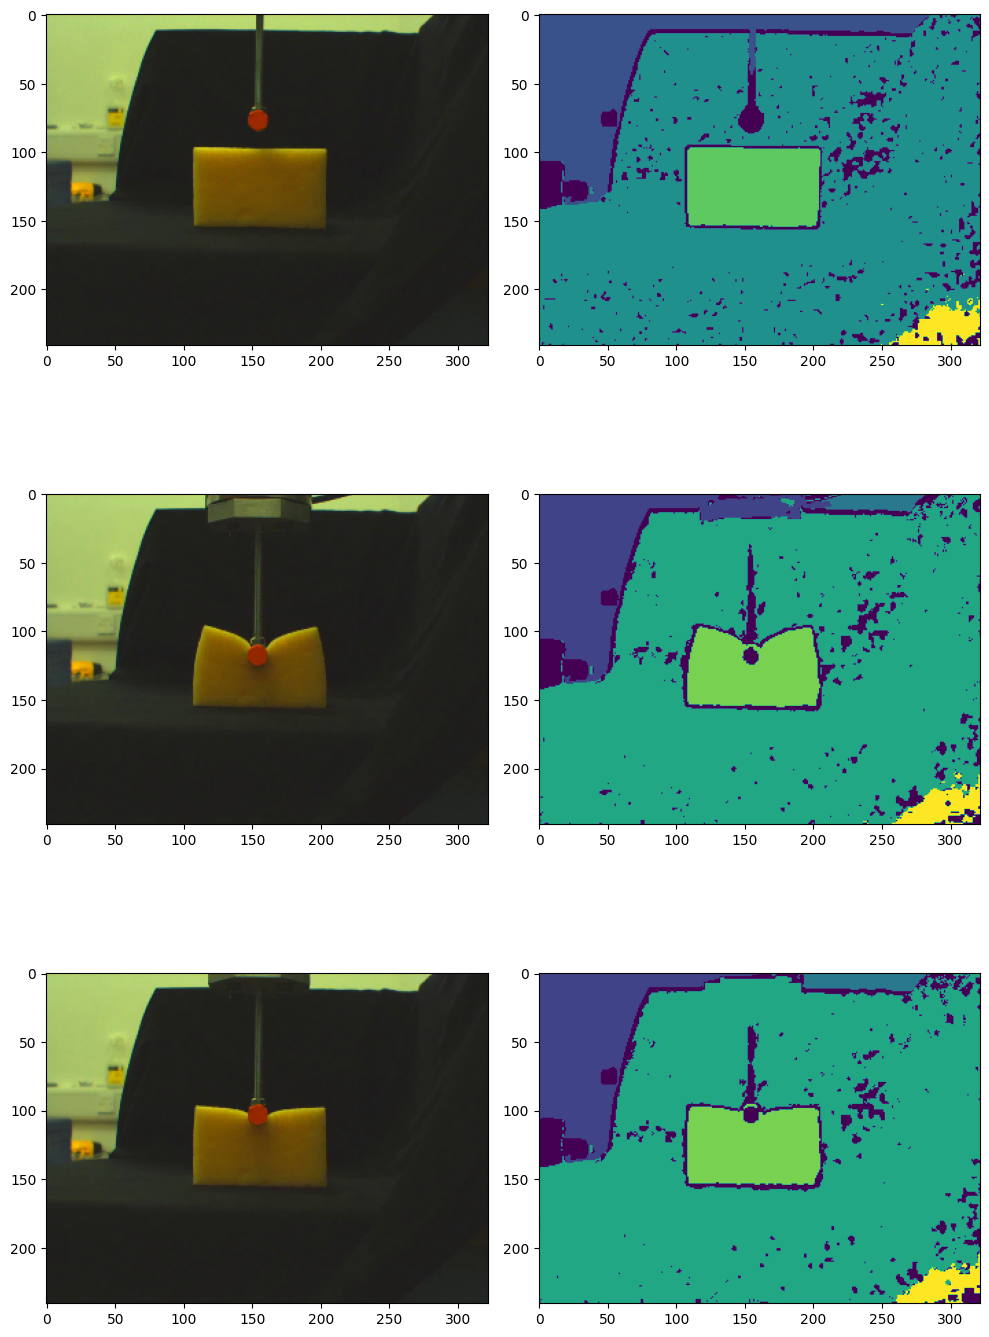

In [25]:
fig, axs = plt.subplots(3,2, figsize = (10,15))

labels = {}
for i, (image_pre, image_real, ax) in enumerate(zip(datos.values(), originals.values(), axs)): # Pendiente por ordenar código
    image_process = image_pre.drop(['V', 'R', 'G', 'B'], axis=1)
    labels[list(datos.keys())[i]] = train_dbscan(image_process, image_real, ax)

fig.tight_layout()

# Evaluación e interpretación

### silhouette_score

In [35]:
from sklearn.metrics import silhouette_score

In [36]:
# min_samples = 776 | $\epsilon = 0.4$
for frame_n in labels.keys():
    real_img = originals[frame_n].reshape(-1,3) # Dimensión correcta para el score
    label = labels[frame_n]
    silhouette_avg = silhouette_score(real_img, label)
    print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.014529332004483544
Silhouette Score: -0.12856202124208205
Silhouette Score: 0.44011084289416225


In [35]:
## min_samples = 776 | $\epsilon = 0.5$
for frame_n in labels.keys():
    real_img = originals[frame_n].reshape(-1,3) # Dimensión correcta para el score
    label = labels[frame_n]
    silhouette_avg = silhouette_score(real_img, label)
    print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.191945348189976
Silhouette Score: 0.09194397050077029
Silhouette Score: 0.14817826923901517


La interpretación del `silhouette_score` nos dice que el mejor valor es 1, mientras que el peor es -1; mientras que valores cercanos a 0 indican grupos superpuestos.

En el último caso, encontramos un score medio de $0.144$. Se puede decir que, si bien no hay una pésima cohesión entre los grupos (pues los score logran ser mayores que cero), sí hay problemas de grupos intercalados. Esto puede ser debido al suavizado gaussiano que se realizó en el preprocesamiento, ya que los contornos en las figuras se suavizaron para reducir el ruido.

Se considera que este valor se puede incrementar si se añaden pasos en el preprocesamiento para eliminar totalmente el ruido de las regiones, intentando mantener un equilibrio con la definición de los bordes de los objetos. Por ejmplo, la realización con parámetros min_samples = 776 | $\epsilon = 0.4$ obtuvo un mayor score en el fotograma 75 ya que pudo separar el punto rojo de la prensa, lo cual no pudo hacer el modelo con $\epsilon = 0.5$.

### DBCV (Density-Based Clustering Validation)

Se intentó realizar esta prueba que, según la literatura, es más apropiada para el ruido en los algoritmos basados en densidad, pero requería un alto espacio en memoria.

In [19]:
import hdbscan

In [ ]:
hdbscan.validity.validity_index(originals[0].reshape(-1,3), labels[0])
# Unable to allocate 8.72 GiB for an array with shape (1170287384,) and data type float64